<a href="https://colab.research.google.com/github/DanielKorenDataScience/RegressionProject/blob/main/Regression%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Laptop Prices prediction using Regression ML model**

# Source link

https://www.kaggle.com/muhammetvarl/laptop-price

# Preliminary


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import sys
import os
import re

# For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances,mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets, linear_model

# For the tree visualization
import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse

# For validation
from sklearn.model_selection import train_test_split as split

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [ ]:
data_url = 'https://raw.githubusercontent.com/DanielKorenDataScience/RegressionProject/master/laptop_price.csv'
resp = requests.get(data_url)
text = resp.text

with open('laptop_price.csv', 'w') as fh:
    fh.write(text)
  
df = pd.read_csv('laptop_price.csv')
df_origin = pd.read_csv('laptop_price.csv')

In [ ]:
df = pd.read_csv('laptop_price.csv', encoding='ISO-8859–1')
df_origin = pd.read_csv('laptop_price.csv', encoding='ISO-8859–1')

# Knowing the data

In [ ]:
df.head(5)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [ ]:
df.nunique()

laptop_ID           1303
Company               19
Product              618
TypeName               6
Inches                18
ScreenResolution      40
Cpu                  118
Ram                    9
Memory                39
Gpu                  110
OpSys                  9
Weight               179
Price_euros          791
dtype: int64

In [ ]:
df.describe()

,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


In [ ]:
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302
laptop_ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320
Company,Apple,Apple,HP,Apple,Apple,Acer,Apple,Apple,Asus,Acer,HP,HP,Apple,Dell,Apple,Apple,Dell,Apple,Lenovo,Dell,Asus,Lenovo,HP,Dell,HP,Dell,Apple,Dell,Dell,HP,Chuwi,Asus,HP,Dell,Apple,Lenovo,Acer,Dell,HP,HP,...,Acer,Dell,Lenovo,HP,Dell,HP,Asus,Lenovo,Lenovo,Lenovo,HP,Asus,Asus,Dell,Acer,Dell,Lenovo,HP,Dell,HP,Asus,Lenovo,Lenovo,Lenovo,HP,Asus,Asus,Dell,Acer,Dell,Lenovo,HP,Dell,HP,Asus,Lenovo,Lenovo,Lenovo,HP,Asus
Product,MacBook Pro,Macbook Air,250 G6,MacBook Pro,MacBook Pro,Aspire 3,MacBook Pro,Macbook Air,ZenBook UX430UN,Swift 3,250 G6,250 G6,MacBook Pro,Inspiron 3567,"MacBook 12""",MacBook Pro,Inspiron 3567,MacBook Pro,IdeaPad 320-15IKB,XPS 13,Vivobook E200HA,Legion Y520-15IKBN,255 G6,Inspiron 5379,15-BS101nv (i7-8550U/8GB/256GB/FHD/W10),Inspiron 3567,MacBook Air,Inspiron 5570,Latitude 5590,ProBook 470,"LapBook 15.6""",E402WA-GA010T (E2-6110/2GB/32GB/W10),17-ak001nv (A6-9220/4GB/500GB/Radeon,XPS 13,MacBook Air,IdeaPad 120S-14IAP,Aspire 3,Inspiron 5770,250 G6,ProBook 450,...,Aspire ES1-531,Inspiron 3552,IdeaPad Y700-15ISK,Pavilion 15-AW003nv,Inspiron 3567,Stream 11-Y000na,X556UJ-XO044T (i7-6500U/4GB/500GB/GeForce,Yoga 500-14ISK,Yoga 900-13ISK,IdeaPad 100S-14IBR,15-AC110nv (i7-6500U/6GB/1TB/Radeon,X553SA-XX031T (N3050/4GB/500GB/W10),ZenBook UX305CA-UBM1,Inspiron 3567,Aspire ES1-531,Inspiron 3552,IdeaPad Y700-15ISK,Pavilion 15-AW003nv,Inspiron 3567,Stream 11-Y000na,X556UJ-XO044T (i7-6500U/4GB/500GB/GeForce,Yoga 500-14ISK,Yoga 900-13ISK,IdeaPad 100S-14IBR,15-AC110nv (i7-6500U/6GB/1TB/Radeon,X553SA-XX031T (N3050/4GB/500GB/W10),ZenBook UX305CA-UBM1,Inspiron 3567,Aspire ES1-531,Inspiron 3552,IdeaPad Y700-15ISK,Pavilion 15-AW003nv,Inspiron 3567,Stream 11-Y000na,X556UJ-XO044T (i7-6500U/4GB/500GB/GeForce,Yoga 500-14ISK,Yoga 900-13ISK,IdeaPad 100S-14IBR,15-AC110nv (i7-6500U/6GB/1TB/Radeon,X553SA-XX031T (N3050/4GB/500GB/W10)
TypeName,Ultrabook,Ultrabook,Notebook,Ultrabook,Ultrabook,Notebook,Ultrabook,Ultrabook,Ultrabook,Ultrabook,Notebook,Notebook,Ultrabook,Notebook,Ultrabook,Ultrabook,Notebook,Ultrabook,Notebook,Ultrabook,Netbook,Gaming,Notebook,2 in 1 Convertible,Ultrabook,Notebook,Ultrabook,Notebook,Ultrabook,Notebook,Notebook,Notebook,Notebook,Ultrabook,Ultrabook,Notebook,Notebook,Notebook,Notebook,Notebook,...,Notebook,Notebook,Notebook,Notebook,Notebook,Netbook,Notebook,2 in 1 Convertible,2 in 1 Convertible,Notebook,Notebook,Notebook,Ultrabook,Notebook,Notebook,Notebook,Notebook,Notebook,Notebook,Netbook,Notebook,2 in 1 Convertible,2 in 1 Convertible,Notebook,Notebook,Notebook,Ultrabook,Notebook,Notebook,Notebook,Notebook,Notebook,Notebook,Netbook,Notebook,2 in 1 Convertible,2 in 1 Convertible,Notebook,Notebook,Notebook
Inches,13.3,13.3,15.6,15.4,13.3,15.6,15.4,13.3,14,14,15.6,15.6,15.4,15.6,12,13.3,15.6,15.4,15.6,13.3,11.6,15.6,15.6,13.3,15.6,15.6,13.3,15.6,15.6,17.3,15.6,14,17.3,13.3,13.3,14,15.6,17.3,15.6,15.6,...,15.6,15.6,15.6,15.6,15.6,11.6,15.6,14,13.3,14,15.6,15.6,13.3,15.6,15.6,15.6,15.6,15.6,15.6,11.6,15.6,14,13.3,14,15.6,15.6,13.3,15.6,15.6,15.6,15.6,15.6,15.6,11.6,15.6,14,13.3,14,15.6,15.6
ScreenResolution,IPS Panel Retina Display 2560x1600,1440x900,Full HD 1920x1080,IPS Panel Retina Display 2880x1800,IPS Panel Retina Display 2560x1600,1366x768,IPS Panel Retina Display 2880x1800,1440x900,Full HD 1920x1080,IPS Panel Full HD 1920x1080,1366x768,Full HD 1920x1080,IPS Panel Retina Display 2880

In [ ]:
df.info(null_counts=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [ ]:
col = list(df.columns)
for column in col: #.split():
    print(column, ':')
#    df[column] = df[column].str.strip()
    print(df[column].value_counts())
    print()

    """ Product, Screen Resolution, CPU, Weight """

laptop_ID :
1320    1
453     1
435     1
436     1
437     1
       ..
880     1
881     1
882     1
883     1
1       1
Name: laptop_ID, Length: 1303, dtype: int64

Company :
Lenovo       297
Dell         297
HP           274
Asus         158
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        9
Mediacom       7
Razer          7
Microsoft      6
Vero           4
Xiaomi         4
Fujitsu        3
Google         3
Chuwi          3
LG             3
Huawei         2
Name: Company, dtype: int64

Product :
XPS 13                                 30
Inspiron 3567                          29
250 G6                                 21
Vostro 3568                            19
Legion Y520-15IKBN                     19
                                       ..
15-BA015wm (E2-7110/4GB/500GB/W10)      1
V110-15IAP (N3350/4GB/128GB/No          1
Portege Z30-C-1CV                       1
15-bs024nv (i5-7200U/8GB/128GB/W10)     1
Latitude E5470                          1

# Conclusions:
1. laptop_ID - Unique, not relevant to the model
2. Company - need to split category to columns
3. Product - ???
4. TypeName - need to split category to columns
5. Inches - need to make rounded
6. ScreenResolution - ???
7. Cpu - I think we should smart seperate to manufacturer and have the model in some other way !?
8. Ram - numeric
9. Memory - storage
10. Gpu - category to column !?
11. OpSys - Important -- category to columns 
12. Weight
13. Price_euros - ***Predict***

# EDA - Data Exploration

In [ ]:
df.head(3)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00


In [ ]:
sns.color_palette("coolwarm", as_cmap=True)
sns.set_theme(style="whitegrid")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


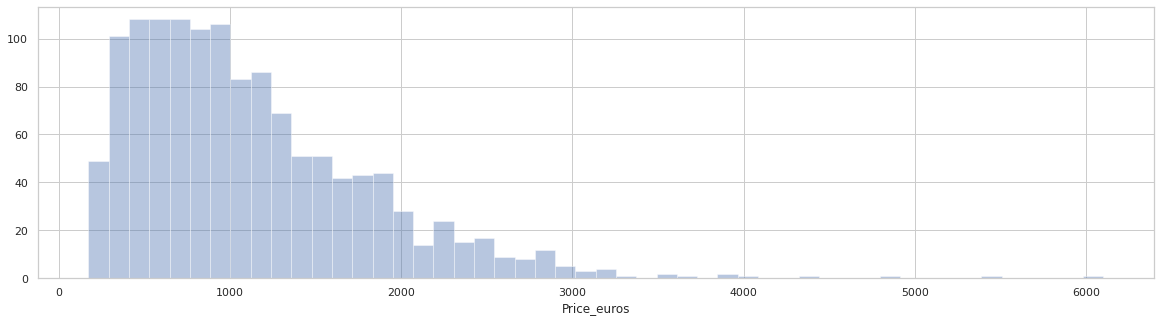

In [ ]:
plt.figure(figsize=(20,5))
sns.distplot(df.Price_euros,bins=50, kde=False)

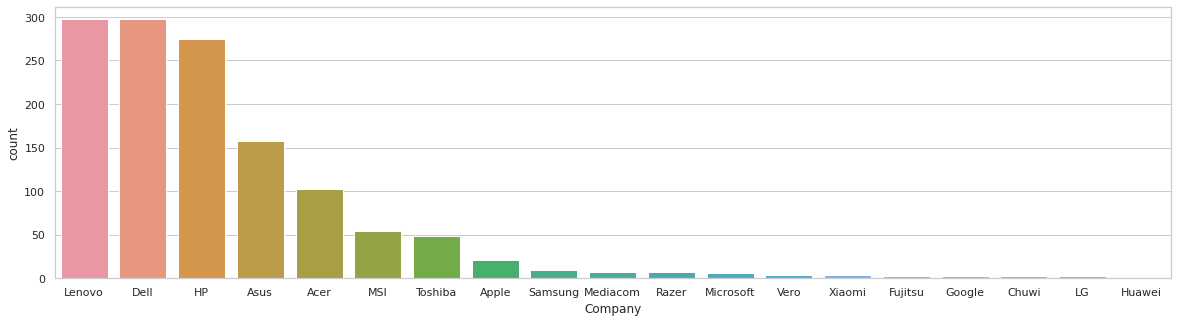

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(data=df, x=df.Company, order = df['Company'].value_counts().index )

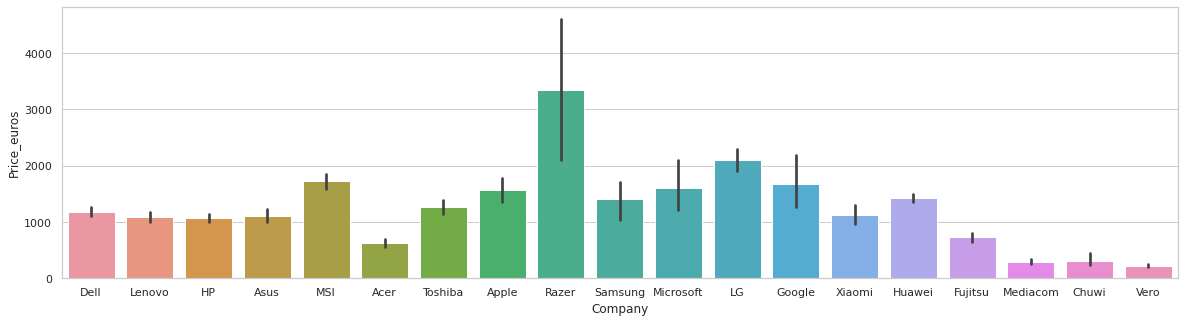

In [ ]:
plt.figure(figsize=(20,5))
plot_order = df.groupby('Company')['Price_euros'].sum().sort_values(ascending=False).index.values
sns.barplot(data=df, x=df.Company, y=df.Price_euros, order=plot_order )

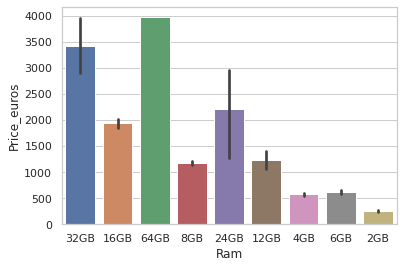

In [ ]:
df.sort_values('Price_euros', inplace=True, ascending=False)
sns.barplot(data=df, x=df['Ram'], y=df['Price_euros'])

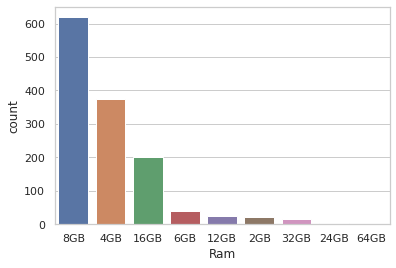

In [ ]:
sns.countplot(data=df, x='Ram', order = df['Ram'].value_counts().index)

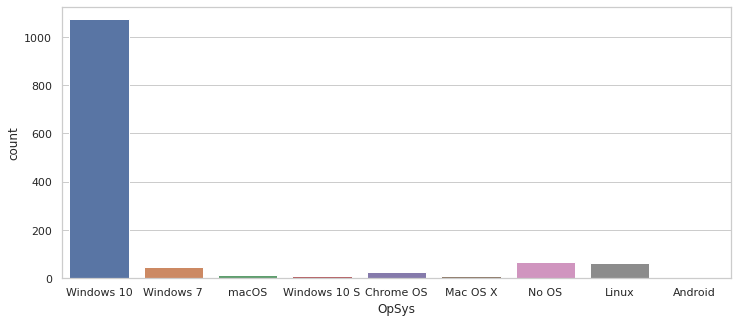

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='OpSys') #, y='Price_euros')

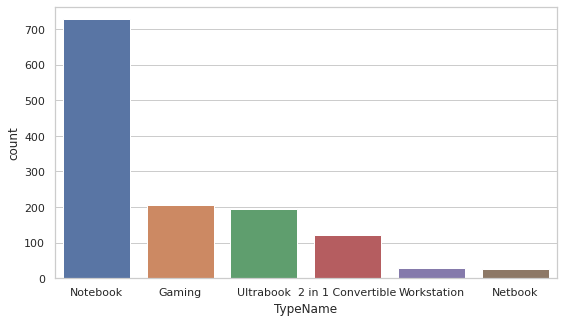

In [ ]:
plt.figure(figsize=(9,5))
plot_order = df.groupby('TypeName')['Price_euros'].count().sort_values(ascending=False).index.values
sns.countplot(data=df, x='TypeName', order=plot_order)

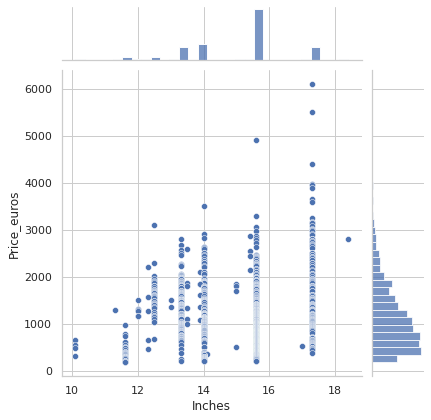

In [ ]:
sns.jointplot(x='Inches',y='Price_euros', kind='scatter', data=df)

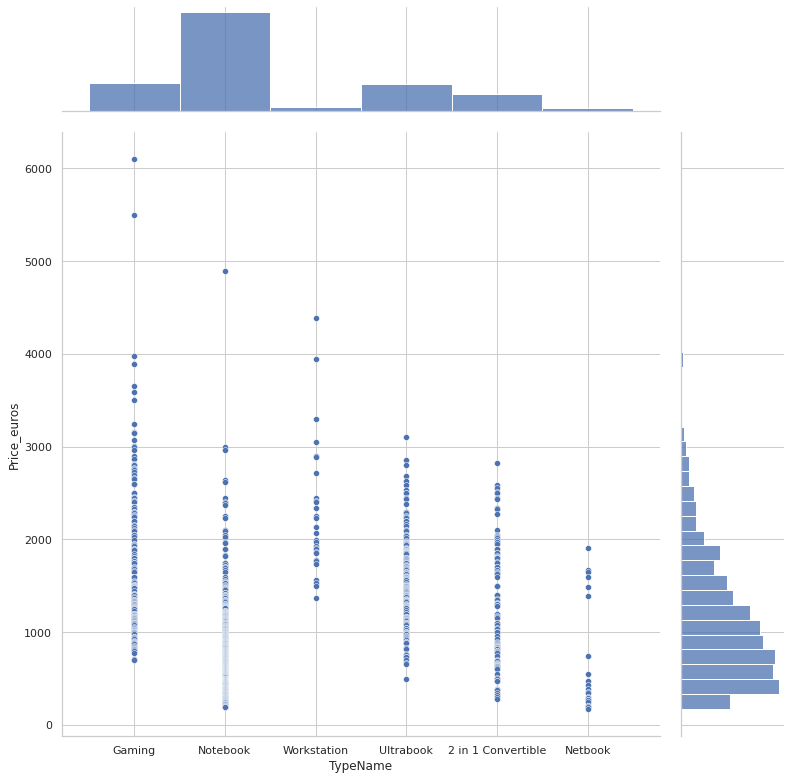

In [ ]:
sns.jointplot(x='TypeName', y='Price_euros', kind='scatter', data=df, height=11)

# Data Cleaning

In [ ]:
df.Price_euros.sort_values().tail(10)

1231    3499.0
780     3588.8
723     3659.4
238     3890.0
1136    3949.4
1066    3975.0
749     4389.0
610     4899.0
830     5499.0
196     6099.0
Name: Price_euros, dtype: float64

In [ ]:
#removing noisy values - prices over 3000
df = df[df['Price_euros'] <= 3000]

# **Dummies Dataset**

# Data Manipulation

In [ ]:
df.nunique()

laptop_ID           1284
Company               19
Product              612
TypeName               6
Inches                18
ScreenResolution      40
Cpu                  116
Ram                    8
Memory                36
Gpu                  107
OpSys                  9
Weight               178
Price_euros          772
dtype: int64

In [ ]:
df.head(2)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
563,570,Lenovo,Thinkpad P71,Notebook,17.3,IPS Panel Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia Quadro M620M,Windows 10,3.4kg,2999.0
247,252,Asus,Rog G701VIK-BA060T,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7820HK 2.9GHz,16GB,256GB SSD,Nvidia GeForce GTX 1080,Windows 10,3.6kg,2999.0


In [ ]:
df_Company = pd.get_dummies(df.Company, prefix='co_')
df_Product = pd.get_dummies(df.Product, prefix='prd_')
df_TypName = pd.get_dummies(df.TypeName, prefix='tpn_')
df_os = pd.get_dummies(df.OpSys, prefix='os_')

In [ ]:
# Round inch information 
df.Inches = df.Inches.round()

# Ram to number
df.Ram = df.Ram.str.replace('GB','').astype(int)

# Weight to number
df.Weight = df.Weight.str.replace('kg','').astype(float)

# Memory to number
df['Memory_SSD']= np.where(df.Memory.str.find("SSD")==-1,0,1)
df['Memory_Flash_Storage']= np.where(df.Memory.str.find("Flash Storage")==-1,0,1)
df['Memory_HDD']= np.where(df.Memory.str.find("HDD")==-1,0,1)
df['Memory_Hybrid']= np.where(df.Memory.str.find("Hybrid")==-1,0,1)
df['Storage_amt'] = df.Memory.str.split().str[0]
storage_map = {'1.0TB':'1000', '1TB':'1000', '2TB':'2000', '508':'500'}
df.Storage_amt.replace(storage_map , inplace=True)
df.Storage_amt = df.Storage_amt.str.replace('GB','').astype(int)

# Split Cpu information 
df['Cpu_brand'] = df.Cpu.str.split().str[0]
df['Cpu_speed'] = df.Cpu.str.split().str[-1]
df.Cpu_speed = df.Cpu_speed.str.split('GHz').str[0].astype(float)
df_Cpu_brand = pd.get_dummies(df.Cpu_brand, prefix='Cpu_')
df['Cpu_HighSeries']=np.where((df.Cpu.str.split(" ",1).str[0]=="AMD") | (df.Cpu.str.split(" ",1).str[0]=="Samsung"),df.Cpu.str.split(" ",1).str[1].str.split(" ",1).str[0],
          np.where((df.Cpu.str.split(" ",1).str[0]=="Intel") & (df.Cpu.str.split(" ",1).str[1].str.split(" ",2).str[0].isin(['Xeon','Atom'])),df.Cpu.str.split(" ",1).str[1].str.split(" ",2).str[0],
          np.where(df.Cpu.str.split(" ",1).str[0]=="Intel",df.Cpu.str.split(" ",1).str[1].str.split(" ",2).str[0]+df.Cpu.str.split(" ",1).str[1].str.split(" ",2).str[1],     
          "missing")))
df_Cpu_HighSeries = pd.get_dummies(df.Cpu_HighSeries, prefix='CpuH_')

test1=df.Cpu.str.split().str[-2].str.split("-").str[-1]
test2=test1.apply(lambda x:re.findall(r'\d+|$',x)[0])
test2.replace([""],["0"],inplace=True)
test2=test2.astype(int)
df['Cpu_LowSeries']=np.where(test2<10,0,test2)

# Split Gpu information
df['Gpu_brand'] = df.Gpu.str.split().str[0]
df_Gpu_brand = pd.get_dummies(df.Gpu_brand, prefix='Gpu_')
df['Gpu_SubType']=np.where(df.Gpu.str.split(" ",2).str[1].isin(['Graphics','R17M-M1-70','Mali','R4']),'missing',df.Gpu.str.split(" ",2).str[1])
df_Gpu_SubType = pd.get_dummies(df.Gpu_SubType, prefix='GpuST_')

# Handle ScreenResolution information
df['Scr_to'] = df.ScreenResolution.str.split('x').str[-1]
df['Scr_to'].astype(int)
df['Scr_from'] = df.ScreenResolution.str.split('x').str[0]
df['Scr_from'] = df.Scr_from.str.split().str[-1]
df['Scr_from'].astype(int)
df['Scr_Touchscreen']=np.where(df.ScreenResolution.str.find("Touchscreen")>-1,1,0)
df['Scr_HD']=np.where(df.ScreenResolution.str.find("Full HD")>-1,'Full_HD',
                    np.where(df.ScreenResolution.str.find("Quad HD")>-1,'Quad_HD',
                    np.where(df.ScreenResolution.str.find("Ultra HD")>-1,'Ultra_HD',
                             'missing')))
df_Scr_HD = pd.get_dummies(df.Scr_HD, prefix='ScrHD_')

In [ ]:
# Combining the Data
df_model = pd.merge(df[['Inches', 'Ram', 'Weight', 'Price_euros', 'Storage_amt', 'Cpu_speed', 'Scr_from', 'Scr_to','Memory_SSD','Memory_Flash_Storage','Memory_HDD','Memory_Hybrid','Cpu_LowSeries','Scr_Touchscreen']], df_Company, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_Product, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_TypName, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_os, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_Cpu_brand, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_Gpu_brand, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_Cpu_HighSeries, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_Gpu_SubType, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_Scr_HD, left_index=True, right_index=True)
#df.drop(['Company', 'Product', 'TypeName', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu', 'OpSys'], axis=1, inplace=True)

df_model.head(2)

,Inches,Ram,Weight,Price_euros,Storage_amt,Cpu_speed,Scr_from,Scr_to,Memory_SSD,Memory_Flash_Storage,Memory_HDD,Memory_Hybrid,Cpu_LowSeries,Scr_Touchscreen,co__Acer,co__Apple,co__Asus,co__Chuwi,co__Dell,co__Fujitsu,co__Google,co__HP,co__Huawei,co__LG,co__Lenovo,co__MSI,co__Mediacom,co__Microsoft,co__Razer,co__Samsung,co__Toshiba,co__Vero,co__Xiaomi,prd__110-15ACL (A6-7310/4GB/500GB/W10),prd__14-am079na (N3710/8GB/2TB/W10),prd__15-AC110nv (i7-6500U/6GB/1TB/Radeon,prd__15-AY023na (N3710/8GB/2TB/W10),prd__15-BA015wm (E2-7110/4GB/500GB/W10),prd__15-BS026nv (i5-7200U/8GB/256GB/Radeon,prd__15-BS028nv (i3-6006U/4GB/1TB/Radeon,...,Cpu__AMD,Cpu__Intel,Cpu__Samsung,Gpu__AMD,Gpu__ARM,Gpu__Intel,Gpu__Nvidia,CpuH__A10-Series,CpuH__A12-Series,CpuH__A4-Series,CpuH__A6-Series,CpuH__A8-Series,CpuH__A9-Series,CpuH__Atom,CpuH__CeleronDual,CpuH__CeleronQuad,CpuH__CoreM,CpuH__Corei3,CpuH__Corei5,CpuH__Corei7,CpuH__Cortex,CpuH__E-Series,CpuH__FX,CpuH__PentiumDual,CpuH__PentiumQuad,CpuH__Ryzen,CpuH__Xeon,GpuST__FirePro,GpuST__GTX,GpuST__GeForce,GpuST__HD,GpuST__Iris,GpuST__Quadro,GpuST__Radeon,GpuST__UHD,GpuST__missing,ScrHD__Full_HD,ScrHD__Quad_HD,ScrHD__Ultra_HD,ScrHD__missing
563,17.0,8,3.4,2999.0,256,2.8,1920,1080,1,0,0,0,7700,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
247,17.0,16,3.6,2999.0,256,2.9,1920,1080,1,0,0,0,7820,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [ ]:
df_model.shape

(1284, 700)

# Baseline Model Functions Predictions

In [ ]:
models = [
    LinearRegression(), 
    DecisionTreeRegressor(), 
    KNeighborsRegressor(),
    RandomForestRegressor()]

def model_name(model):
    return type(model).__name__

def rmse(a, b):
    return mse(a, b) **0.5

def rmsle(a,b):
    return msle(a,b) ** 0.5

def score_model_(stage, y, y_pred, is_log_scale):
    # display(pd.Series(y).describe())
    # display(pd.Series(y_pred).describe())

    if not is_log_scale:
        rmse_error = rmse(y, y_pred)
        # MSLE cannot be used with negative values
        rmsle_error = rmsle(y, y_pred.clip(min=0))    
    else:
        rmsle_error = rmse(y, y_pred)
        rmse_error = rmse(np.expm1(y), np.expm1(y_pred))

    rmsp_error = np.round(100*(np.expm1(rmsle_error)), 2)
    
    return pd.DataFrame({
        f"{stage}_rmse": rmse_error,
        f"{stage}_rmsle": rmsle_error,
        f"{stage}_rms%": rmsp_error
    }, index=[0])

def score_model(model, y_train, y_train_pred, y_test, y_test_pred, is_log_scale):
    # score the model
    results = score_model_('train', y_train, y_train_pred, is_log_scale)
    results = results.join(score_model_('test', y_test, y_test_pred, is_log_scale))
    results['model'] = model_name(model)
    return results.set_index('model')

def fit_and_score(X_train, y_train, X_test, y_test, is_log_scale):
    df = pd.DataFrame()
    for model in models:
        # learn the model
        model.fit(X_train, y_train)

        # create train/test predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # score the model
        results = score_model(model, y_train, y_train_pred,  y_test, y_test_pred, is_log_scale)
        df = df.append(results)

    return df


In [ ]:
X = df_model.drop('Price_euros', axis=1)
y = df_model['Price_euros']
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

fit_and_score(X_train, y_train, X_test, y_test, is_log_scale=False)

,train_rmse,train_rmsle,train_rms%,test_rmse,test_rmsle,test_rms%
model,,,,,,
LinearRegression,107.718307,0.085924,8.97,301.932586,0.281570,32.52
DecisionTreeRegressor,26.916112,0.020352,2.06,338.769887,0.253327,28.83
KNeighborsRegressor,258.841251,0.225658,25.31,336.127752,0.271727,31.22
RandomForestRegressor,93.482643,0.077055,8.01,289.675725,0.216229,24.14


# Decision Tree Model

In [ ]:
X = df_model.drop('Price_euros', axis=1)
y = df_model['Price_euros']
feature_list = list(X.columns)

In [ ]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [ ]:
model = DecisionTreeRegressor(max_depth=11, min_samples_leaf=21).fit(X_train, y_train)

In [ ]:
y_train_pred = model.predict(X_train)

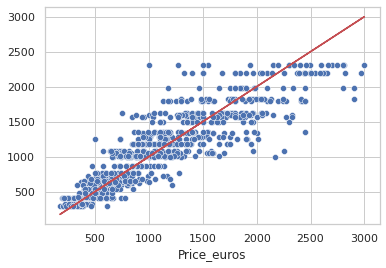

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

273.6778710794051

In [ ]:
RMSLE = rmsle(y_train, y_train_pred.clip(min=0)) 
RMSLE

0.2382089389913956

In [ ]:
RMSP = np.round(100*(np.expm1(RMSLE)), 2)
RMSP

26.9

In [ ]:
y_test_pred = model.predict(X_test)

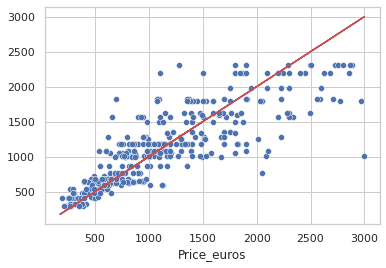

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

348.01631546221904

In [ ]:
RMSLE = rmsle(y_test, y_test_pred.clip(min=0)) 
RMSLE

0.281557596193176

In [ ]:
RMSP = np.round(100*(np.expm1(RMSLE)), 2)
RMSP

32.52

Text(0.5, 8.95999999999998, 'prediction error')

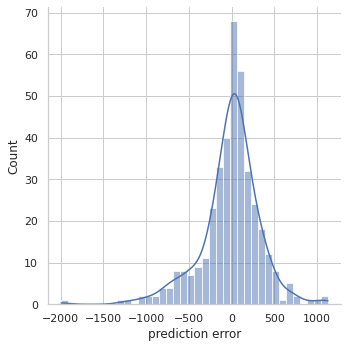

In [ ]:
sns.displot(y_test_pred - y_test, kde=True)
plt.xlabel('prediction error')

In [ ]:
testDf=pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred})

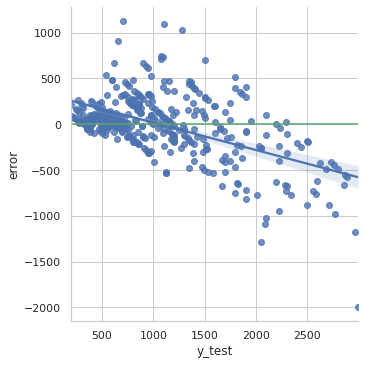

In [ ]:
sns.lmplot(
    x='y_test', 
    y='error',
    data=testDf.assign(error = testDf['y_test_pred'] - testDf['y_test'])
)
#plt.ylim(np.array(plt.xlim())*1.2)
plt.axhline(0, c='g')

Text(0.5, 0, 'min samples per leaf')

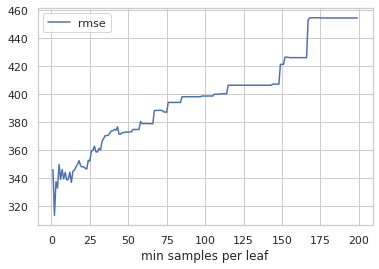

In [ ]:
rmse_list = []

min_samples_leaf_range = range(1, 200)

result = pd.DataFrame(index=min_samples_leaf_range, columns =['rmse'])

for i in min_samples_leaf_range:
    model = DecisionTreeRegressor(min_samples_leaf=i)
    model.fit(X_train, y_train)
    y_fit = model.predict(X_test)
    rmse = np.sqrt(mse(y_test, y_fit))
    result.loc[i, 'rmse'] = rmse


result.plot()
plt.xlabel('min samples per leaf')

Text(0.5, 0, 'max depth')

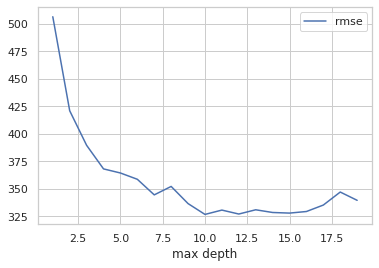

In [ ]:
rmse_list = []

max_depth = range(1, 20)

result = pd.DataFrame(index=max_depth, columns =['rmse'])

for i in max_depth:
    model = DecisionTreeRegressor(max_depth=i)
    model.fit(X_train, y_train)
    y_fit = model.predict(X_test)
    rmse = np.sqrt(mse(y_test, y_fit))
    result.loc[i, 'rmse'] = rmse




result.plot()
plt.xlabel('max depth')

Text(0.5, 0, 'min_samples_split')

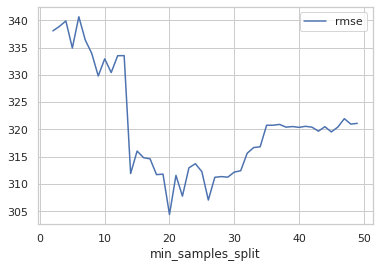

In [ ]:
rmse_list = []

min_samples_split = range(2, 50)

result = pd.DataFrame(index=max_depth, columns =['rmse'])

for i in min_samples_split:
    model = DecisionTreeRegressor(min_samples_split=i)
    model.fit(X_train, y_train)
    y_fit = model.predict(X_test)
    rmse = np.sqrt(mse(y_test, y_fit))
    result.loc[i, 'rmse'] = rmse


#display(result.head(30))
result.plot()
plt.xlabel('min_samples_split')

In [ ]:
def visualize_tree(model, md=5):
    dot_data = StringIO()  
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
    return Image(graph.create_png(), width=800) 

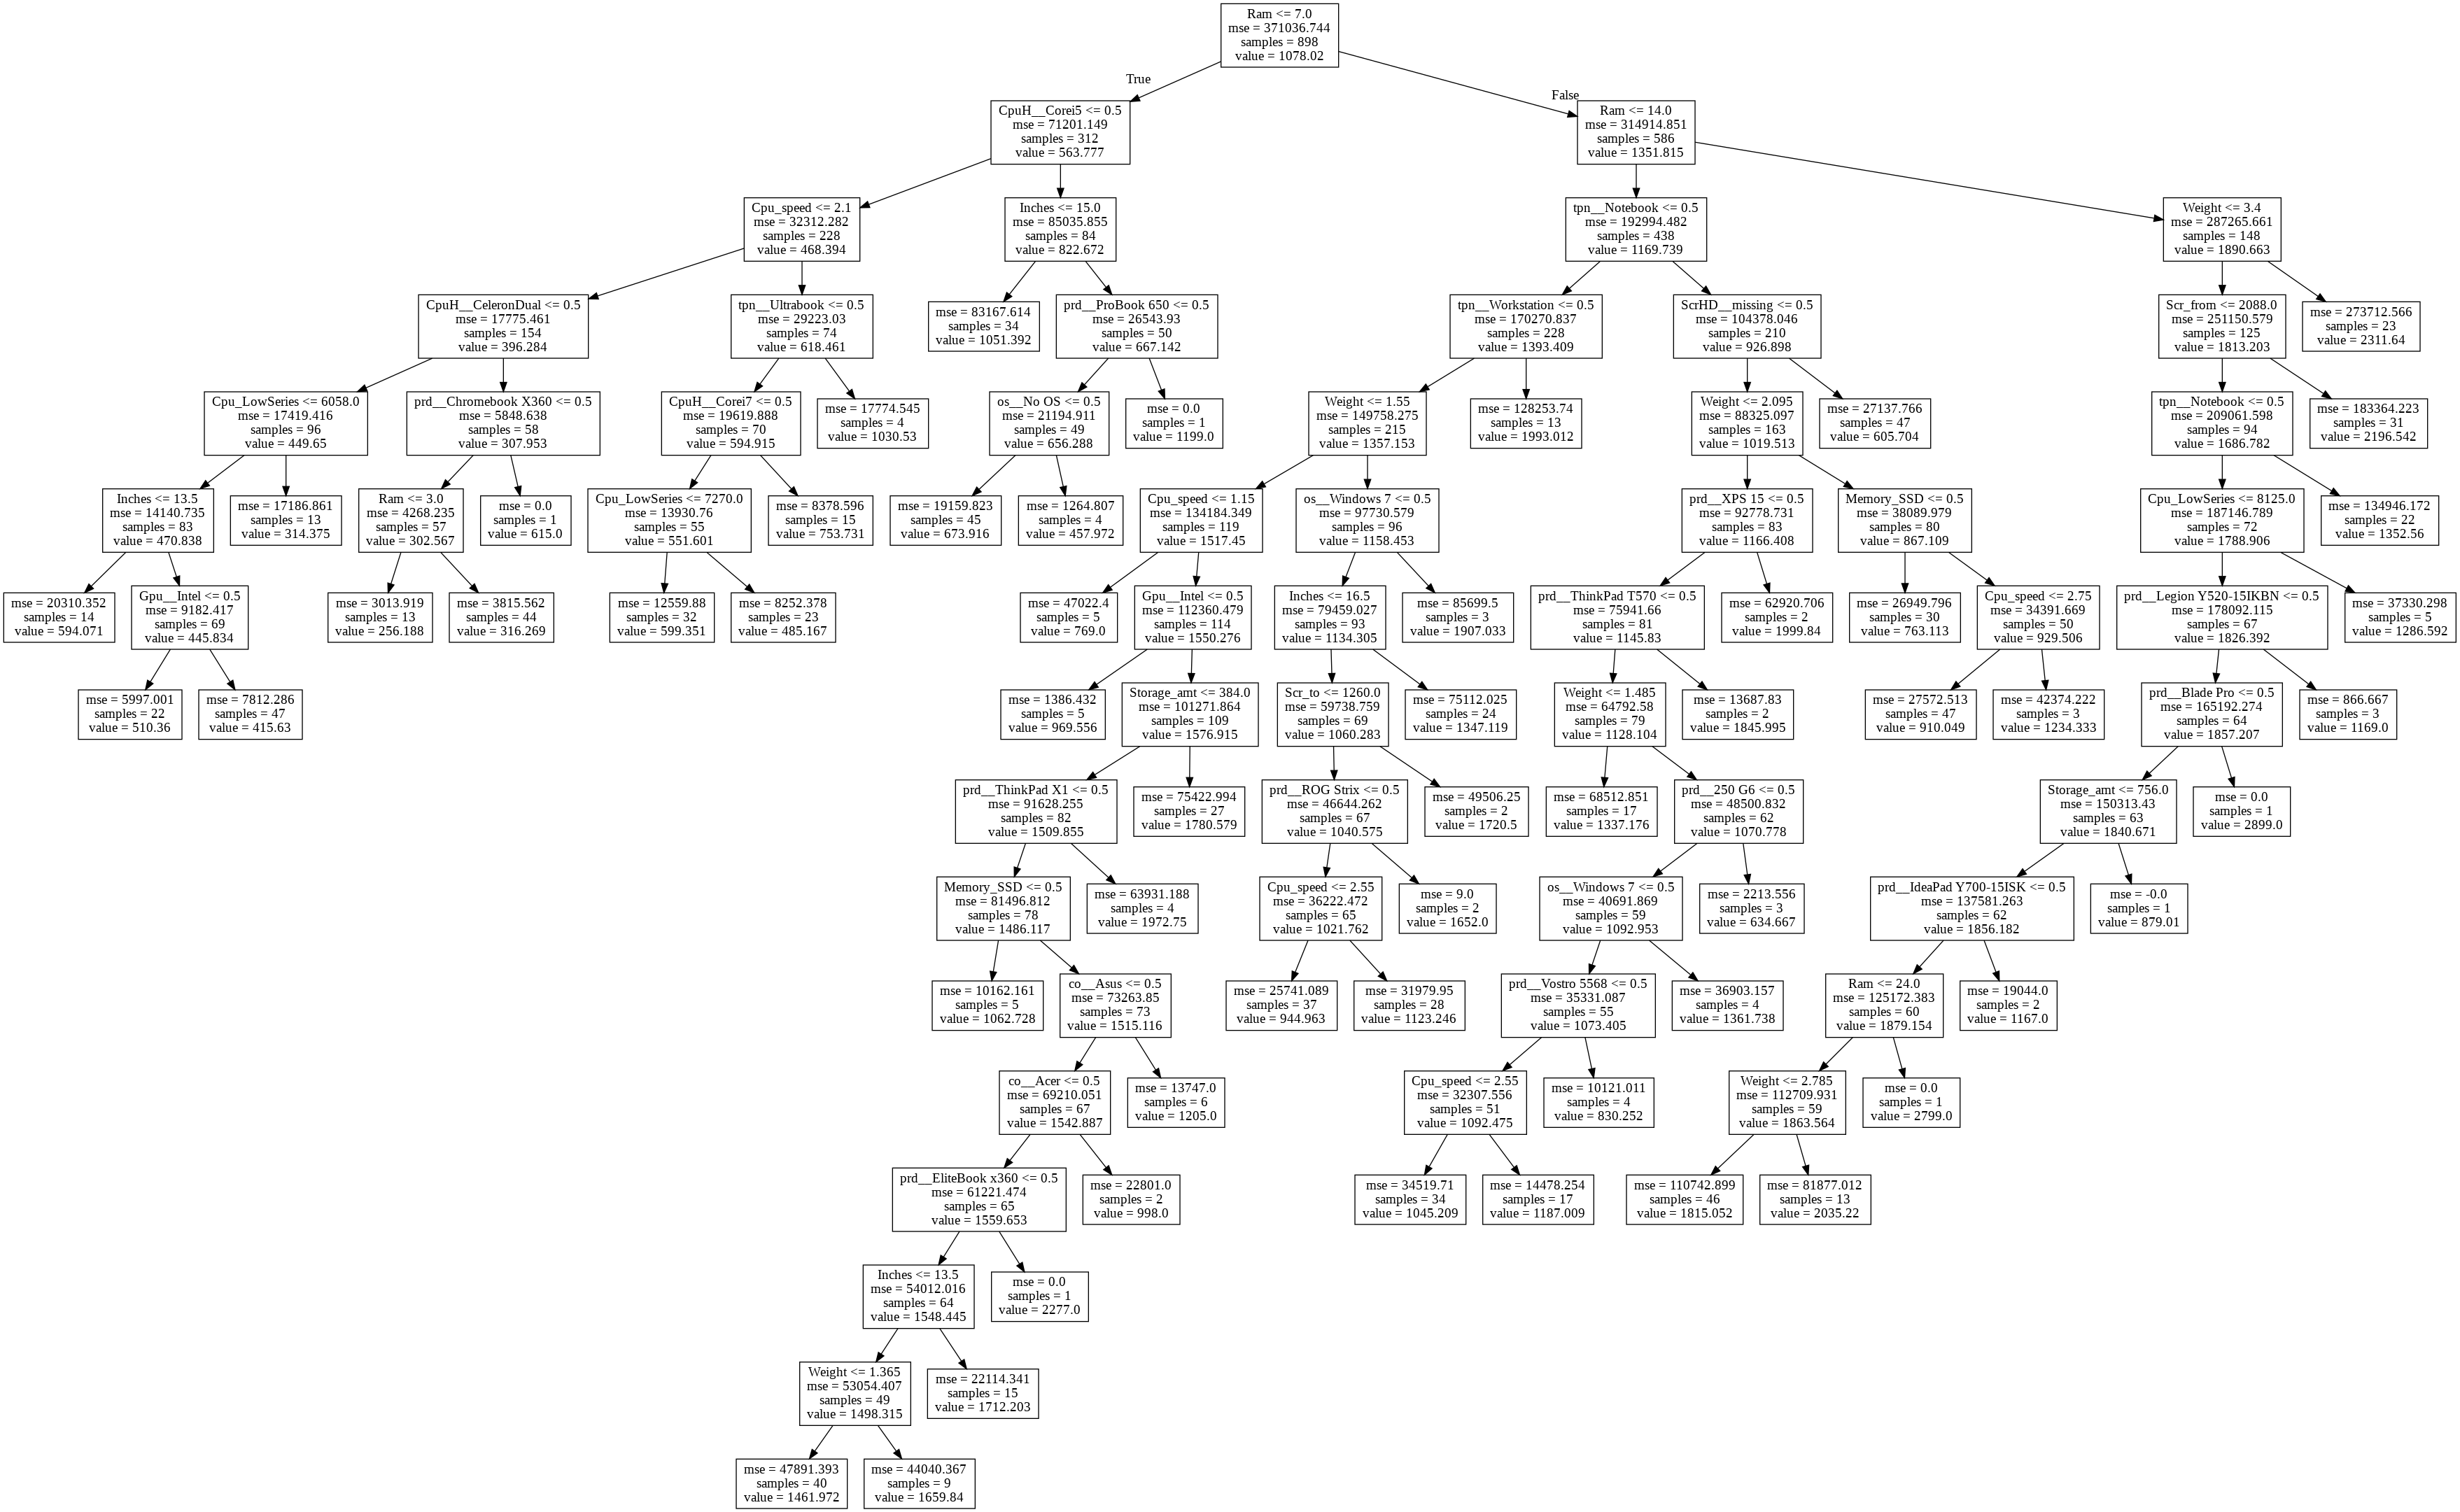

In [ ]:
visualize_tree(model, md=100)

In [ ]:
importances = model.feature_importances_

In [ ]:
importances[::-1].sort() 

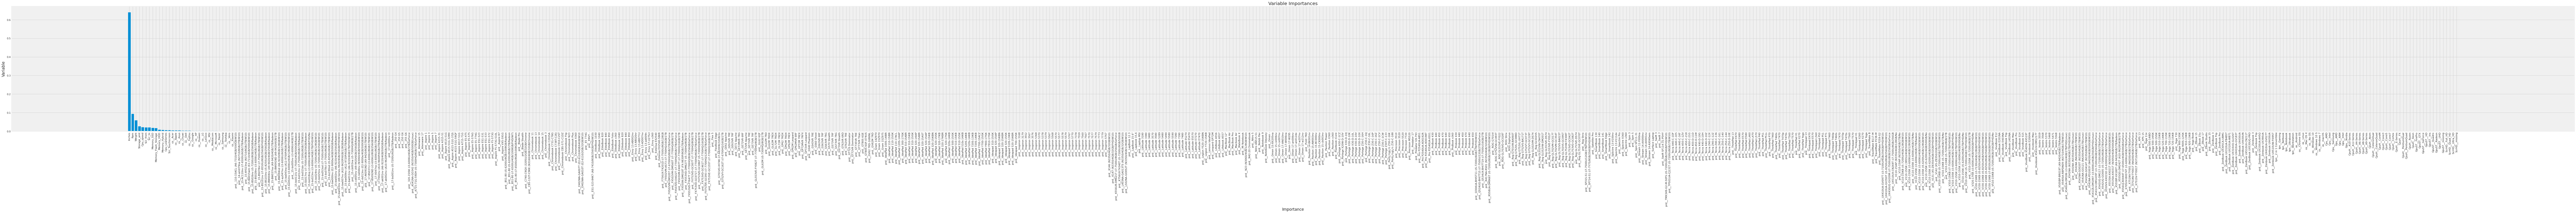

In [ ]:
plt.figure(figsize=(200,10))
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances');

In [ ]:
#model = RandomForestClassifier()
model = DecisionTreeRegressor(max_depth=13, min_samples_leaf=3,min_samples_split=20).fit(X_train, y_train)

In [ ]:
y_train_pred = model.predict(X_train)

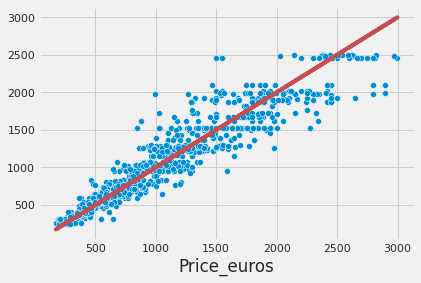

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')
#sns.set(font_scale=1.2)

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

207.40190875640116

In [ ]:
RMSLE = rmsle(y_train, y_train_pred.clip(min=0)) 
RMSLE

0.17065740543477992

In [ ]:
RMSP = np.round(100*(np.expm1(RMSLE)), 2)
RMSP

18.61

In [ ]:
y_test_pred = model.predict(X_test)

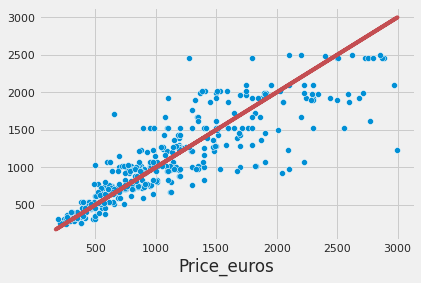

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

316.54225792881107

In [ ]:
RMSLE = rmsle(y_test, y_test_pred.clip(min=0)) 
RMSLE

0.244422912657706

In [ ]:
RMSP = np.round(100*(np.expm1(RMSLE)), 2)
RMSP

27.69

Text(0.5, 11.120000000000005, 'prediction error')

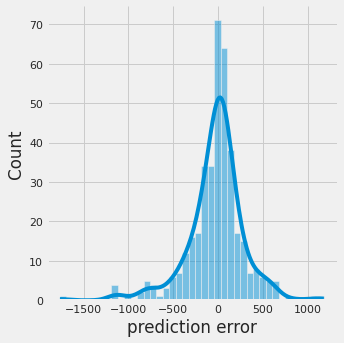

In [ ]:
sns.displot(y_test_pred - y_test, kde=True)
plt.xlabel('prediction error')

In [ ]:
testDf=pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred})

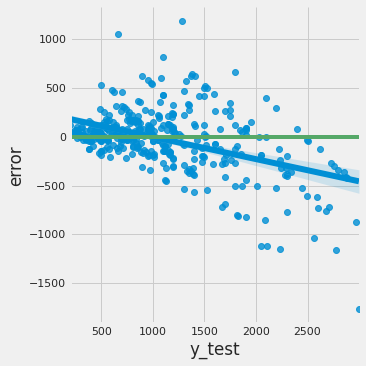

In [ ]:
sns.lmplot(
    x='y_test', 
    y='error',
    data=testDf.assign(error = testDf['y_test_pred'] - testDf['y_test'])
)
#plt.ylim(np.array(plt.xlim())*1.2)
plt.axhline(0, c='g')

In [ ]:
importances[::-1].sort() 

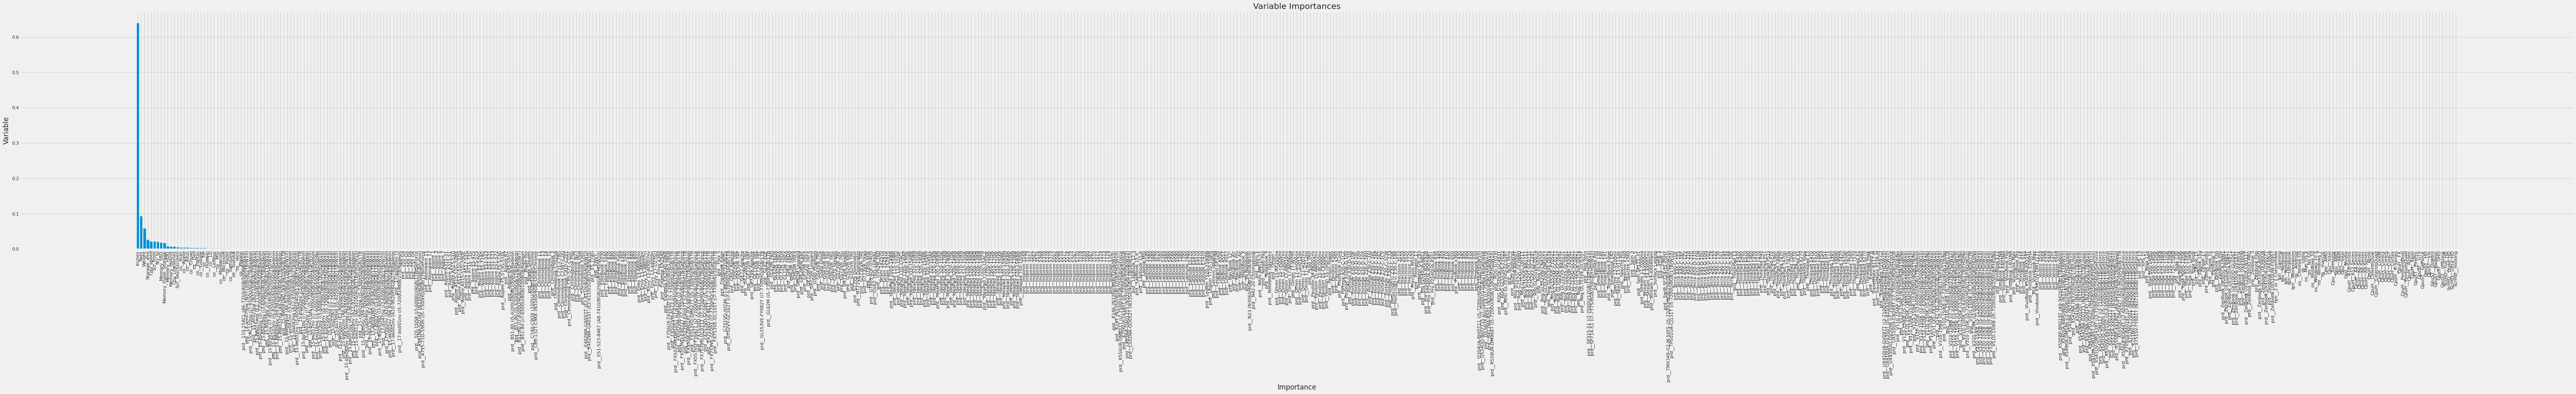

In [ ]:
plt.figure(figsize=(100,10))
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances');

# Random Forest Model

In [ ]:
X = df_model.drop('Price_euros', axis=1)
y = df_model['Price_euros']
feature_list = list(X.columns)

In [ ]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [ ]:
# Use the forest's predict method on the test data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(y_test_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 184.83 degrees.


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 83.46 %.


In [ ]:
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
#(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
#graph.write_png('tree.png')

In [ ]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=200, max_depth = 16, bootstrap = True, max_features = 'auto', min_samples_split = 2)
rf_small.fit(X_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree1.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree1.dot')
graph.write_png('small_tree.png');

In [ ]:
# display small_tree.png
Image(filename='small_tree.png') 

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')
sns.set(font_scale=1.2)

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

In [ ]:
RMSLE = rmsle(y_train, y_train_pred.clip(min=0)) 
RMSLE

In [ ]:
RMSP = np.round(100*(np.expm1(RMSLE)), 2)
RMSP

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

289.89744018258364

In [ ]:
RMSLE = rmsle(y_test, y_test_pred.clip(min=0)) 
RMSLE

0.216452379562532

In [ ]:
RMSP = np.round(100*(np.expm1(RMSLE)), 2)
RMSP

24.17

In [ ]:
sns.displot(y_test_pred - y_test, kde=True)
plt.xlabel('prediction error')

In [ ]:
testDf=pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred})

In [ ]:
sns.lmplot(
    x='y_test', 
    y='error',
    data=testDf.assign(error = testDf['y_test_pred'] - testDf['y_test'])
)
#plt.ylim(np.array(plt.xlim())*1.2)
plt.axhline(0, c='g')

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
importances[::-1].sort() 

In [ ]:
plt.figure(figsize=(100,10))
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances');

In [ ]:
def Grid_Search_CV_RFR(X_train, y_train):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import ShuffleSplit
    from sklearn.ensemble import RandomForestRegressor

    estimator = RandomForestRegressor()
    param_grid = { 
            "n_estimators"      : [10,200,500,1000],
            "max_features"      : ["auto", "sqrt", "log2"],
            "max_depth" :[4,8,10,12,16,20],
            "min_samples_split" : [2,4,8,10,12],
            "bootstrap": [True, False],
            }

    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

    grid.fit(X_train, y_train)

    return grid.best_score_ , grid.best_params_

In [ ]:
#Grid_Search_CV_RFR(X_train,y_train)

# Linear Regression Model

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
X = df_model.drop('Price_euros', axis=1)
y = df_model['Price_euros']
feature_list = list(X.columns)

X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [ ]:
#print(__doc__)

In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [ ]:
print(regr.intercept_)

In [ ]:
# The coefficients
print('Coefficients: \n', regr.coef_)

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_train_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

In [ ]:
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
plt.scatter(y_test, y_pred)
plt.plot(y_test,y_test,  c='red')
plt.title('Price in EUR - Actual vs Predicted', size=20)
plt.show()

In [ ]:
sns.displot(y_pred - y_test, kde=True)
plt.xlabel('prediction error (EUR)')

# K Nearest Neighbors Model

In [ ]:
X = df_model.drop('Price_euros', axis=1)
y = df_model['Price_euros']
feature_list = list(X.columns)

X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [ ]:
model = KNeighborsRegressor(n_neighbors=6)
model.fit(X, y)

In [ ]:
y_train_pred = model.predict(X_train)

In [ ]:
pd.Series(y_train_pred).value_counts()

In [ ]:
y_test_pred = model.predict(X_test)

In [ ]:
pd.Series(y_test_pred).value_counts()

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

In [ ]:
RMSLE = rmsle(y_train, y_train_pred.clip(min=0)) 
RMSLE

In [ ]:
RMSP = np.round(100*(np.expm1(RMSLE)), 2)
RMSP

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')
sns.set(font_scale=1.2)

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

In [ ]:
RMSLE = rmsle(y_test, y_test_pred.clip(min=0)) 
RMSLE

In [ ]:
RMSP = np.round(100*(np.expm1(RMSLE)), 2)
RMSP

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')
sns.set(font_scale=1.2)

In [ ]:
sns.displot(y_test_pred - y_test, kde=True)
plt.xlabel('prediction error')

In [ ]:
testDf=pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred})

In [ ]:
sns.lmplot(
    x='y_test', 
    y='error',
    data=testDf.assign(error = testDf['y_test_pred'] - testDf['y_test'])
)
#plt.ylim(np.array(plt.xlim())*1.2)
plt.axhline(0, c='g')

In [ ]:
#features=X_train.columns
#importances = model.feature_importances_
#indices = np.argsort(importances)
#sns.set(font_scale=1)
#plt.figure(figsize=(10,10))
#plt.figure(1)
#plt.title('Feature Importances Price')
#plt.barh(range(len(indices)), importances[indices], color='b', align='center')
#plt.yticks(range(len(indices)), features[indices])
#plt.xlabel('Relative Importance')

# **Categorical Dataset**

# Data Manipulation

In [ ]:
df_origin.head(2)

In [ ]:
def GroupPrice(GroupValue,dfOrg):
  df_origin=dfOrg.groupby(GroupValue).agg({'Price_euros':[('avgPrice','mean'),('stdPrice',np.std)],'laptop_ID':[('countLaptop','count')]}).reset_index()
  df_origin.columns=df_origin.columns.droplevel(0)
  df_origin.columns.values[0]=GroupValue
  df_origin.sort_values('countLaptop',ascending=False,inplace=True)
  valueByPrice=df_origin.sort_values('avgPrice',ascending=False)[GroupValue].tolist()
  print(valueByPrice)
  dict_map = dict(zip(valueByPrice, range(len(valueByPrice))))
  dfOrg.loc[:, GroupValue+'Num'] = dfOrg[GroupValue].map(dict_map)
  return dfOrg

In [ ]:
df_origin=GroupPrice('Company',df_origin)
#display(df_origin[['Company','CompanyNum']].head(10))

In [ ]:
types=GroupPrice('TypeName',df_origin)
#display(types[['TypeName','TypeNameNum']].head(10))

In [ ]:
df_origin['Scr_HD']=np.where(df_origin.ScreenResolution.str.find("Full HD")>-1,'Full_HD',
                    np.where(df_origin.ScreenResolution.str.find("Quad HD")>-1,'Quad_HD',
                    np.where(df_origin.ScreenResolution.str.find("Ultra HD")>-1,'Ultra_HD',
                             'missing')))
df_origin=GroupPrice('Scr_HD',df_origin)
#display(df_origin[['Scr_HD','Scr_HDNum']].head(10))

In [ ]:
df_origin['Cpu_HighSeries']=np.where((df_origin.Cpu.str.split(" ",1).str[0]=="AMD") | (df_origin.Cpu.str.split(" ",1).str[0]=="Samsung"),df_origin.Cpu.str.split(" ",1).str[1].str.split(" ",1).str[0],
          np.where((df_origin.Cpu.str.split(" ",1).str[0]=="Intel") & (df_origin.Cpu.str.split(" ",1).str[1].str.split(" ",2).str[0].isin(['Xeon','Atom'])),df_origin.Cpu.str.split(" ",1).str[1].str.split(" ",2).str[0],
          np.where(df_origin.Cpu.str.split(" ",1).str[0]=="Intel",df_origin.Cpu.str.split(" ",1).str[1].str.split(" ",2).str[0]+df_origin.Cpu.str.split(" ",1).str[1].str.split(" ",2).str[1],     
          "missing")))
df_origin=GroupPrice('Cpu_HighSeries',df_origin)
#display(df_origin[['Cpu_HighSeries','Cpu_HighSeriesNum']].head(10))

In [ ]:
df_origin['Gpu_brand'] = df_origin.Gpu.str.split().str[0]
df_origin=GroupPrice('Gpu_brand',df_origin)
#display(df_origin[['Gpu_brand','Gpu_brandNum']].head(10))

In [ ]:
df_origin['Gpu_SubType']=np.where(df_origin.Gpu.str.split(" ",2).str[1].isin(['Graphics','R17M-M1-70','Mali','R4']),'missing',df_origin.Gpu.str.split(" ",2).str[1])
df_origin=GroupPrice('Gpu_SubType',df_origin)
#display(df_origin[['Gpu_SubType','Gpu_SubTypeNum']].head(10))

In [ ]:
df_origin=GroupPrice('OpSys',df_origin)
#display(df_origin[['OpSys','OpSysNum']].head(10))

In [ ]:
df_origin.Ram = df_origin.Ram.str.replace('GB','').astype(int)

In [ ]:
df_origin.Weight = df_origin.Weight.str.replace('kg','').astype(float)

In [ ]:
df_origin.Inches = df_origin.Inches.round()

In [ ]:
df_origin['Storage_amt'] = df_origin.Memory.str.split().str[0]
storage_map = {'1.0TB':'1000', '1TB':'1000', '2TB':'2000', '508':'500'}
df_origin.Storage_amt.replace(storage_map , inplace=True)
df_origin.Storage_amt = df_origin.Storage_amt.str.replace('GB','').astype(int)

In [ ]:
df_origin['Cpu_speed'] = df_origin.Cpu.str.split().str[-1]
df_origin.Cpu_speed = df_origin.Cpu_speed.str.split('GHz').str[0].astype(float)

In [ ]:
test1=df_origin.Cpu.str.split().str[-2].str.split("-").str[-1]
test2=test1.apply(lambda x:re.findall(r'\d+|$',x)[0])
test2.replace([""],["0"],inplace=True)
test2=test2.astype(int)
df_origin['Cpu_LowSeries']=np.where(test2<10,0,test2)


In [ ]:
df_origin['Scr_to'] = df_origin.ScreenResolution.str.split('x').str[-1]
df_origin['Scr_to'].astype(int)
df_origin['Scr_from'] = df_origin.ScreenResolution.str.split('x').str[0]
df_origin['Scr_from'] = df_origin.Scr_from.str.split().str[-1]
df_origin['Scr_from'].astype(int)
df_origin['Scr_Touchscreen']=np.where(df_origin.ScreenResolution.str.find("Touchscreen")>-1,1,0)

In [ ]:
df_origin['Memory_SSD']= np.where(df_origin.Memory.str.find("SSD")==-1,0,1)
df_origin['Memory_Flash_Storage']= np.where(df_origin.Memory.str.find("Flash Storage")==-1,0,1)
df_origin['Memory_HDD']= np.where(df_origin.Memory.str.find("HDD")==-1,0,1)
df_origin['Memory_Hybrid']= np.where(df_origin.Memory.str.find("Hybrid")==-1,0,1)

In [ ]:
df_origin.head(2)

In [ ]:
df_model_cat=df_origin[['Inches', 'Ram', 'Weight',  'Storage_amt', 'Cpu_speed', 'Scr_from', 'Scr_to','Memory_SSD','Memory_Flash_Storage','Memory_HDD','Memory_Hybrid','Cpu_LowSeries',
             'Scr_Touchscreen','CompanyNum','TypeNameNum','Scr_HDNum','Cpu_HighSeriesNum','Gpu_brandNum','Gpu_SubTypeNum','OpSysNum','Price_euros']].copy()

In [ ]:
df_model_cat.loc[1000]

In [ ]:
df_model_cat.Inches.astype(float)
df_model_cat.Ram.astype(float)
df_model_cat.Storage_amt.astype(float)
df_model_cat.Cpu_speed.astype(float)
df_model_cat.Scr_from = df_model_cat.Scr_from.astype(int)
df_model_cat.Scr_to = df_model_cat.Scr_to.astype(int)
df_model_cat.Memory_SSD.astype(float)
df_model_cat.Memory_Flash_Storage.astype(float)
df_model_cat.Memory_HDD.astype(float)
df_model_cat.Memory_Hybrid.astype(float)
df_model_cat.Cpu_LowSeries.astype(float)
df_model_cat.Scr_Touchscreen.astype(float)
df_model_cat.CompanyNum.astype(float)
df_model_cat.TypeNameNum.astype(float)
df_model_cat.Scr_HDNum.astype(float)
df_model_cat.Cpu_HighSeriesNum.astype(float)
df_model_cat.Gpu_brandNum.astype(float)
df_model_cat.Gpu_SubTypeNum.astype(float)
df_model_cat.OpSysNum.astype(float)

In [ ]:
df_model_cat.shape

In [ ]:
df_model_cat.info()

In [ ]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(40,20))        
# Imbalanced DataFrame Correlation
corr = df_model_cat.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':20},annot=True, ax=ax)
sns.set(font_scale=2)
ax.set_title("Correlation Matrix", fontsize=25)
plt.show()

In [ ]:
sns.set(font_scale=1)

In [ ]:
def rmsle(a,b):
    return msle(a,b) ** 0.5

# Decision Tree Model

In [ ]:
X = df_model_cat.drop('Price_euros', axis=1)
y = df_model_cat['Price_euros']
feature_list = list(X.columns)

In [ ]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [ ]:
model_cat = DecisionTreeRegressor(max_depth=6, min_samples_leaf=4,min_samples_split=16).fit(X_train, y_train)

In [ ]:
y_train_pred = model_cat.predict(X_train)

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')
# sns.set(font_scale=1.2)

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

In [ ]:
y_test_pred = model_cat.predict(X_test)

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

In [ ]:
RMSLE = rmsle(y_test, y_test_pred.clip(min=0)) 
RMSLE

In [ ]:
RMSP = np.round(100*(np.expm1(RMSLE)), 2)
RMSP

In [ ]:
sns.displot(y_test_pred - y_test, kde=True)
plt.xlabel('prediction error')

In [ ]:
testDf=pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred})

In [ ]:
sns.lmplot(
    x='y_test', 
    y='error',
    data=testDf.assign(error = testDf['y_test_pred'] - testDf['y_test'])
)
#plt.ylim(np.array(plt.xlim())*1.2)
plt.axhline(0, c='g')

In [ ]:
rmse_list = []

min_samples_leaf_range = range(1, 200)

result = pd.DataFrame(index=min_samples_leaf_range, columns =['rmse'])

for i in min_samples_leaf_range:
    model_cat = DecisionTreeRegressor(min_samples_leaf=i)
    model_cat.fit(X_train, y_train)
    y_fit = model_cat.predict(X_test)
    rmse = np.sqrt(mse(y_test, y_fit))
    result.loc[i, 'rmse'] = rmse




result.plot()
plt.xlabel('min samples per leaf')

In [ ]:
result.head(20)

In [ ]:
rmse_list = []

max_depth = range(1, 20)

result = pd.DataFrame(index=max_depth, columns =['rmse'])

for i in max_depth:
    model_cat = DecisionTreeRegressor(max_depth=i)
    model_cat.fit(X_train, y_train)
    y_fit = model_cat.predict(X_test)
    rmse = np.sqrt(mse(y_test, y_fit))
    result.loc[i, 'rmse'] = rmse




result.plot()
plt.xlabel('max depth')

In [ ]:
result.head(30)

In [ ]:
rmse_list = []

min_samples_split = range(2, 50)

result = pd.DataFrame(index=min_samples_split, columns =['rmse'])

for i in min_samples_split:
    model_cat = DecisionTreeRegressor(min_samples_split=i)
    model_cat.fit(X_train, y_train)
    y_fit = model_cat.predict(X_test)
    rmse = np.sqrt(mse(y_test, y_fit))
    result.loc[i, 'rmse'] = rmse


display(result.head(30))
result.plot()
plt.xlabel('min_samples_split')

In [ ]:
def visualize_tree(model_cat, md=5):
    dot_data = StringIO()  
    export_graphviz(model_cat, out_file=dot_data, feature_names=X_train.columns, max_depth=md)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
    return Image(graph.create_png(), width=800) 

In [ ]:
visualize_tree(model_cat, md=10)

In [ ]:
features=X_train.columns
importances = model_cat.feature_importances_
indices = np.argsort(importances)
sns.set(font_scale=1)
plt.figure(figsize=(10,10))
plt.figure(1)
plt.title('Feature Importances Price')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

# remove Ram

In [ ]:
X_train.columns

In [ ]:
X.shape

In [ ]:
df_model_cat.shape

In [ ]:
X = df_model_cat.drop(['Price_euros','Ram'], axis=1)
y = df_model_cat['Price_euros']
feature_list = list(X.columns)

In [ ]:
X.shape

In [ ]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [ ]:
model_cat = DecisionTreeRegressor(max_depth=9, min_samples_leaf=15,min_samples_split=18).fit(X_train, y_train)

In [ ]:
y_train_pred = model_cat.predict(X_train)

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')
sns.set(font_scale=1.2)

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

In [ ]:
y_test_pred = model_cat.predict(X_test)

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

In [ ]:
RMSLE = rmsle(y_test, y_test_pred.clip(min=0)) 
RMSLE

In [ ]:
RMSP = np.round(100*(np.expm1(RMSLE)), 2)
RMSP

In [ ]:
sns.displot(y_test_pred - y_test, kde=True)
plt.xlabel('prediction error')

In [ ]:
testDf=pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred})

In [ ]:
sns.lmplot(
    x='y_test', 
    y='error',
    data=testDf.assign(error = testDf['y_test_pred'] - testDf['y_test'])
)
#plt.ylim(np.array(plt.xlim())*1.2)
plt.axhline(0, c='g')

In [ ]:
features=X_train.columns
importances = model_cat.feature_importances_
indices = np.argsort(importances)
sns.set(font_scale=1)
plt.figure(figsize=(10,10))
plt.figure(1)
plt.title('Feature Importances Price')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [ ]:
rmse_list = []

min_samples_leaf_range = range(1, 200)

result = pd.DataFrame(index=min_samples_leaf_range, columns =['rmse'])

for i in min_samples_leaf_range:
    model_cat = DecisionTreeRegressor(min_samples_leaf=i)
    model_cat.fit(X_train, y_train)
    y_fit = model_cat.predict(X_test)
    rmse = np.sqrt(mse(y_test, y_fit))
    result.loc[i, 'rmse'] = rmse




result.plot()
plt.xlabel('min samples per leaf')

In [ ]:
result.head(20)

In [ ]:
rmse_list = []

max_depth = range(1, 20)

result = pd.DataFrame(index=max_depth, columns =['rmse'])

for i in max_depth:
    model_cat = DecisionTreeRegressor(max_depth=i)
    model_cat.fit(X_train, y_train)
    y_fit = model_cat.predict(X_test)
    rmse = np.sqrt(mse(y_test, y_fit))
    result.loc[i, 'rmse'] = rmse




result.plot()
plt.xlabel('max depth')

In [ ]:
result.head(30)

In [ ]:
rmse_list = []

min_samples_split = range(2, 50)

result = pd.DataFrame(index=min_samples_split, columns =['rmse'])

for i in min_samples_split:
    model_cat = DecisionTreeRegressor(min_samples_split=i)
    model_cat.fit(X_train, y_train)
    y_fit = model_cat.predict(X_test)
    rmse = np.sqrt(mse(y_test, y_fit))
    result.loc[i, 'rmse'] = rmse


display(result.head(30))
result.plot()
plt.xlabel('min_samples_split')

# remove all prediction more 3000

In [ ]:
df_model_less3000=df_model_cat[df_model_cat['Price_euros']<=3000]

In [ ]:
df_model_less3000.shape

In [ ]:
X = df_model_less3000.drop(['Price_euros'], axis=1)
y = df_model_less3000['Price_euros']
feature_list = list(X.columns)

In [ ]:
X.shape

In [ ]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [ ]:
rmse_list = []

min_samples_leaf_range = range(1, 200)

result = pd.DataFrame(index=min_samples_leaf_range, columns =['rmse'])

for i in min_samples_leaf_range:
    model = DecisionTreeRegressor(min_samples_leaf=i)
    model.fit(X_train, y_train)
    y_fit = model.predict(X_test)
    rmse = np.sqrt(mse(y_test, y_fit))
    result.loc[i, 'rmse'] = rmse




result.plot()
plt.xlabel('min samples per leaf')

In [ ]:
result.head(20)

In [ ]:
rmse_list = []

max_depth = range(1, 20)

result = pd.DataFrame(index=max_depth, columns =['rmse'])

for i in max_depth:
    model = DecisionTreeRegressor(max_depth=i)
    model.fit(X_train, y_train)
    y_fit = model.predict(X_test)
    rmse = np.sqrt(mse(y_test, y_fit))
    result.loc[i, 'rmse'] = rmse




result.plot()
plt.xlabel('max depth')

In [ ]:
result.head(30)

In [ ]:
rmse_list = []

min_samples_split = range(2, 50)

result = pd.DataFrame(index=min_samples_split, columns =['rmse'])

for i in min_samples_split:
    model = DecisionTreeRegressor(min_samples_split=i)
    model.fit(X_train, y_train)
    y_fit = model.predict(X_test)
    rmse = np.sqrt(mse(y_test, y_fit))
    result.loc[i, 'rmse'] = rmse


display(result.head(30))
result.plot()
plt.xlabel('min_samples_split')

In [ ]:
model = DecisionTreeRegressor(max_depth=8, min_samples_leaf=9,min_samples_split=18).fit(X_train, y_train)

In [ ]:
y_train_pred = model.predict(X_train)

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')
sns.set(font_scale=1.2)

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

In [ ]:
y_test_pred = model.predict(X_test)

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

In [ ]:
RMSLE = rmsle(y_test, y_test_pred.clip(min=0)) 
RMSLE

In [ ]:
RMSP = np.round(100*(np.expm1(RMSLE)), 2)
RMSP

In [ ]:
sns.displot(y_test_pred - y_test, kde=True)
plt.xlabel('prediction error')

In [ ]:
testDf=pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred})

In [ ]:
sns.lmplot(
    x='y_test', 
    y='error',
    data=testDf.assign(error = testDf['y_test_pred'] - testDf['y_test'])
)
#plt.ylim(np.array(plt.xlim())*1.2)
plt.axhline(0, c='g')

In [ ]:
features=X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)
sns.set(font_scale=1)
plt.figure(figsize=(10,10))
plt.figure(1)
plt.title('Feature Importances Price')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

# Random Forest Model

In [ ]:
X = df_model_less3000.drop('Price_euros', axis=1)
y = df_model_less3000['Price_euros']
feature_list = list(X.columns)

In [ ]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [ ]:
X.shape

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [ ]:
# Use the forest's predict method on the test data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(y_test_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')
sns.set(font_scale=1.2)

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

In [ ]:
RMSLE = rmsle(y_test, y_test_pred.clip(min=0)) 
RMSLE

In [ ]:
RMSP = np.round(100*(np.expm1(RMSLE)), 2)
RMSP

In [ ]:
sns.displot(y_test_pred - y_test, kde=True)
plt.xlabel('prediction error')

In [ ]:
testDf=pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred})

In [ ]:
sns.lmplot(
    x='y_test', 
    y='error',
    data=testDf.assign(error = testDf['y_test_pred'] - testDf['y_test'])
)
#plt.ylim(np.array(plt.xlim())*1.2)
plt.axhline(0, c='g')

In [ ]:
features=X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
sns.set(font_scale=1)
plt.figure(figsize=(10,10))
plt.figure(1)
plt.title('Feature Importances Price')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [ ]:
def Grid_Search_CV_RFR(X_train, y_train):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import ShuffleSplit
    from sklearn.ensemble import RandomForestRegressor

    estimator = RandomForestRegressor()
    param_grid = { 
            "n_estimators"      : [10,200,500,1000],
            "max_features"      : ["auto", "sqrt", "log2"],
            "max_depth" :[4,8,10,12,16,20],
            "min_samples_split" : [2,4,8,10,12],
            "bootstrap": [True, False],
            }

    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

    grid.fit(X_train, y_train)

    return grid.best_score_ , grid.best_params_

In [ ]:
# Grid_Search_CV_RFR(X_train,y_train)

# randomForest after Grid search


In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000,max_depth=12,max_features='log2',min_samples_split=2,bootstrap=False, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [ ]:
# Use the forest's predict method on the test data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(y_test_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')
sns.set(font_scale=1.2)

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

In [ ]:
RMSLE = rmsle(y_test, y_test_pred.clip(min=0)) 
RMSLE

In [ ]:
RMSP = np.round(100*(np.expm1(RMSLE)), 2)
RMSP

In [ ]:
sns.set(rc={'figure.figsize':(15,13)})
sns.displot(y_test_pred - y_test, kde=True)
plt.xticks(list(range(-1500,1500,300)))
plt.xlabel('prediction error')
plt.show()

In [ ]:
testDf=pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred})

In [ ]:
sns.lmplot(
    x='y_test', 
    y='error',
    data=testDf.assign(error = testDf['y_test_pred'] - testDf['y_test'])
)
#plt.ylim(np.array(plt.xlim())*1.2)
plt.axhline(0, c='g')

In [ ]:
features=X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
sns.set(font_scale=1)
plt.figure(figsize=(10,10))
plt.figure(1)
plt.title('Feature Importances Price')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

# change columns type to category

In [ ]:
df_model_less3000.head(5)

In [ ]:
categoryCols=['CompanyNum','TypeNameNum','Scr_HDNum','Cpu_HighSeriesNum','Gpu_brandNum','Gpu_SubTypeNum','OpSysNum']

In [ ]:
df_modelSetCat=df_model_less3000.copy()
df_modelSetCat[categoryCols]=df_modelSetCat[categoryCols].apply(lambda x: x.astype('category'))

In [ ]:
df_modelSetCat.info()

In [ ]:
X = df_modelSetCat.drop('Price_euros', axis=1)
y = df_modelSetCat['Price_euros']
feature_list = list(X.columns)

In [ ]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [ ]:
X.shape

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000,max_depth=12,max_features='log2',min_samples_split=2,bootstrap=False, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [ ]:
# Use the forest's predict method on the test data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(y_test_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

In [ ]:
RMSLE = rmsle(y_test, y_test_pred.clip(min=0)) 
RMSLE

In [ ]:
RMSP = np.round(100*(np.expm1(RMSLE)), 2)
RMSP

In [ ]:
features=X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
sns.set(font_scale=1)
plt.figure(figsize=(10,10))
plt.figure(1)
plt.title('Feature Importances Price')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

# split data

In [ ]:
df_modelMore3K=df_model_cat[df_model_cat['Price_euros']>1500]
df_modelLess3K=df_model_cat[df_model_cat['Price_euros']<=1500]
print(df_modelMore3K.shape)
print(df_modelLess3K.shape)

In [ ]:
def runModel(df_model_cat):
    X = df_model_cat.drop('Price_euros', axis=1)
    y = df_model_cat['Price_euros']
    feature_list = list(X.columns)
    X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)
    X_train, X_test, y_train, y_test
    print(X.shape)
    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 1000,max_depth=12,max_features='log2',min_samples_split=2,bootstrap=False, random_state = 42)
    # Train the model on training data
    rf.fit(X_train, y_train)
    # Use the forest's predict method on the test data
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    # Calculate the absolute errors
    errors = abs(y_test_pred - y_test)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    
    ax = sns.scatterplot(x=y_train, y=y_train_pred)
    ax.plot(y_train, y_train, 'r')
    plt.show()
    RMSE = mse(y_train, y_train_pred)**0.5
    print(' train RMSE is ', RMSE)
    ax = sns.scatterplot(x=y_test, y=y_test_pred)
    ax.plot(y_train, y_train, 'r')
    plt.show()
    RMSE = mse(y_test, y_test_pred)**0.5
    print('test RMSE is ',RMSE)

    RMSLE = rmsle(y_test, y_test_pred.clip(min=0)) 
    print('test RMSLE is ',RMSLE)
    
    RMSP = np.round(100*(np.expm1(RMSLE)), 2)
    print('test RMSLP is ',RMSP)
    features=X_train.columns
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)
    sns.set(font_scale=1)
    plt.figure(figsize=(10,10))
    plt.figure(1)
    plt.title('Feature Importances Price')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    pd.DataFrame({'y_test':y_test,'y_test_pred': y_test_pred})  
    
    return pd.concat([X_test,pd.DataFrame({'y_test':y_test,'y_test_pred': y_test_pred})],axis=1),pd.DataFrame({'y_train': y_train,'y_train_pred': y_train_pred}),rf

In [ ]:
def resModel(y_train, y_train_pred,y_test,y_test_pred):
    ax = sns.scatterplot(x=y_train, y=y_train_pred)
    ax.plot(y_train, y_train, 'r')
    plt.show()
    RMSE = mse(y_train, y_train_pred)**0.5
    print(' train RMSE is ', RMSE)
    ax = sns.scatterplot(x=y_test, y=y_test_pred)
    ax.plot(y_train, y_train, 'r')
    plt.show()
    RMSE = mse(y_test, y_test_pred)**0.5
    print('test RMSE is ',RMSE)

    RMSLE = rmsle(y_test, y_test_pred)# .clip(min=0) 
    print('test RMSLE is ',RMSLE)
    
    RMSP = np.round(100*(np.expm1(RMSLE)), 2)
    print('test RMSLP is ',RMSP)
    
#     sns.set(rc={'figure.figsize':(15,13)})
#     sns.displot(y_test_pred - y_test, kde=True)
#     plt.xticks(list(range(-1500,1500,300)))
#     plt.xlabel('prediction error')
#     plt.show()
    
    testDf=pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred})

    sns.lmplot(
        x='y_test', 
        y='error',
        data=testDf.assign(error = testDf['y_test_pred'] - testDf['y_test'])
    )
    #plt.ylim(np.array(plt.xlim())*1.2)
    plt.axhline(0, c='g')
    plt.show()
    
    return 

In [ ]:
resDFLess3K=runModel(df_modelLess3K)

In [ ]:
resDFLess3K[1].head(1)

In [ ]:
resDFMore3K=runModel(df_modelMore3K)

In [ ]:
resDfTestBoth=resDFMore3K[0].append(resDFLess3K[0])
resDfTrainBoth=resDFMore3K[1].append(resDFLess3K[1])
print(resDfTestBoth.shape)
print(resDfTrainBoth.shape)

In [ ]:
resDfTrainBoth.head()

In [ ]:
resDFMore3K[0].shape

In [ ]:
resModel(resDfTrainBoth.y_train,resDfTrainBoth.y_train_pred,resDfTestBoth.y_test,resDfTestBoth.y_test_pred)

# split less then 3000

In [ ]:
df_model_less3000.shape

In [ ]:
df_modelMore15K=df_model_less3000[df_model_less3000['Price_euros']>1500]
df_modelLess15K=df_model_less3000[df_model_less3000['Price_euros']<=1500]
print(df_modelMore15K.shape)
print(df_modelLess15K.shape)

In [ ]:
resDFLess15K=runModel(df_modelLess15K)

In [ ]:
resDFMore15K[1].shape

In [ ]:
resDFMore15K=runModel(df_modelMore15K)

In [ ]:
resDfTestBoth_=resDFMore15K[0].append(resDFLess15K[0])
resDfTrainBoth_=resDFMore15K[1].append(resDFLess15K[1])
print(resDfTestBoth.shape)
print(resDfTrainBoth.shape)

In [ ]:
resModel(resDfTrainBoth_.y_train,resDfTrainBoth_.y_train_pred,resDfTestBoth_.y_test,resDfTestBoth_.y_test_pred)

In [ ]:
pd.set_option('display.max_columns', 25)

In [ ]:
resDfTestBoth_.columns

In [ ]:
resDfTestBoth_['Error']=abs(resDfTestBoth_['y_test']-resDfTestBoth_['y_test_pred'])

In [ ]:
resDfTestBoth_.sort_values('Error',ascending=False).head(10)

In [ ]:
companies=df_origin[['Company','CompanyNum']].drop_duplicates()

companies.head()

In [ ]:
resDfTestBoth_.info()

In [ ]:
resDfTestBoth_.merge(companies,on='CompanyNum',how='inner')\
    .sort_values('Error',ascending=False)\
    [['Weight','Ram','Storage_amt','Cpu_speed','Company','CompanyNum','Cpu_HighSeriesNum','Memory_SSD','Cpu_LowSeries',
      'y_test_pred','y_test','Error']].head(10)

In [ ]:
resDfTestBoth_.merge(companies,on='CompanyNum',how='inner')\
    .sort_values('Error',ascending=False)\
    [['Weight','Ram','Storage_amt','Cpu_speed','Company','CompanyNum','Cpu_HighSeriesNum','Memory_SSD','Cpu_LowSeries',
      'y_test_pred','y_test','Error']].tail(10)

# Final DF

In [7]:
modelsDF=pd.DataFrame(columns=['# model','ModelType','Categorial type','Change Description','RMSE train','RMSE test','RMSLE test','RMSP test'])
modelsDF.head()

,# model,ModelType,Categorial type,Change Description,RMSE train,RMSE test,RMSLE test,RMSP test


In [8]:
modelsDF=modelsDF.append({'# model':1,'ModelType':'DecisionTree','Categorial type':'dummies','Change Description':'filter price more than 3000 EUR ','RMSE train':207,
                 'RMSE test':348,'RMSLE test':0.28,'RMSP test':32.52},ignore_index=True)
modelsDF=modelsDF.append({'# model':2,'ModelType':'DecisionTree','Categorial type':'numeric by price','Change Description':'remove Ram from model','RMSE train':354,
                 'RMSE test':346,'RMSLE test':0.26,'RMSP test':30.01},ignore_index=True)
modelsDF=modelsDF.append({'# model':3,'ModelType':'DecisionTree','Categorial type':'numeric by price','Change Description':'first model','RMSE train':333,
                 'RMSE test':330,'RMSLE test':0.25,'RMSP test':28.69},ignore_index=True)
modelsDF=modelsDF.append({'# model':4,'ModelType':'RandomForset','Categorial type':'dummies','Change Description':'filter price more than 3000 EUR','RMSE train':91,
                 'RMSE test':289,'RMSLE test':0.21,'RMSP test':24.17},ignore_index=True)
modelsDF=modelsDF.append({'# model':5,'ModelType':'DecisionTree','Categorial type':'numeric by price','Change Description':'filter price more than 3000 EUR','RMSE train':271,
                 'RMSE test':272,'RMSLE test':0.24,'RMSP test':27.14},ignore_index=True)
modelsDF=modelsDF.append({'# model':6,'ModelType':'KNN','Categorial type':'dummies','Change Description':'filter price more than 3000 EUR','RMSE train':261,
                 'RMSE test':269,'RMSLE test':0.21,'RMSP test':23.57},ignore_index=True)
modelsDF=modelsDF.append({'# model':7,'ModelType':'linner regression','Categorial type':'dummies','Change Description':'filter price more than 3000 EUR','RMSE train':107,
                 'RMSE test':268,'RMSLE test':0.21,'RMSP test':23.57},ignore_index=True)
modelsDF=modelsDF.append({'# model':8,'ModelType':'RandomForest','Categorial type':'numeric by price','Change Description':'filter price more than 3000 EUR,change hyper parameters after grid search','RMSE train':122,
                 'RMSE test':222,'RMSLE test':0.19,'RMSP test':21.52},ignore_index=True)
modelsDF=modelsDF.append({'# model':9,'ModelType':'RandomForest','Categorial type':'numeric by price','Change Description':'filter price more than 3000 EUR,change categorial columns to categoty type','RMSE train':122,
                 'RMSE test':222,'RMSLE test':0.19,'RMSP test':21.52},ignore_index=True)
modelsDF=modelsDF.append({'# model':10,'ModelType':'RandomForest','Categorial type':'numeric by price','Change Description':'filter price more than 3000 EUR,default Hyper parameters with 1000 estimators','RMSE train':100,
                 'RMSE test':219,'RMSLE test':0.18,'RMSP test':20.81},ignore_index=True)
modelsDF=modelsDF.append({'# model':11,'ModelType':'RandomForest','Categorial type':'numeric by price','Change Description':'split data for two models with more and less than 1500 price.without filter more 3000 EUR','RMSE train':70,
                 'RMSE test':198,'RMSLE test':0.16,'RMSP test':17.82},ignore_index=True)
modelsDF=modelsDF.append({'# model':12,'ModelType':'RandomForest','Categorial type':'numeric by price','Change Description':'split data for two models with more and less than 1500 price.with filter of more 3000 EUR','RMSE train':69,
                 'RMSE test':167,'RMSLE test':0.16,'RMSP test':17.4},ignore_index=True)


In [9]:
modelsDF

,# model,ModelType,Categorial type,Change Description,RMSE train,RMSE test,RMSLE test,RMSP test
0,1,DecisionTree,dummies,filter price more than 3000 EUR,207,348,0.28,32.52
1,2,DecisionTree,numeric by price,remove Ram from model,354,346,0.26,30.01
2,3,DecisionTree,numeric by price,first model,333,330,0.25,28.69
3,4,RandomForset,dummies,filter price more than 3000 EUR,91,289,0.21,24.17
4,5,DecisionTree,numeric by price,filter price more than 3000 EUR,271,272,0.24,27.14
5,6,KNN,dummies,filter price more than 3000 EUR,261,269,0.21,23.57
6,7,linner regression,dummies,filter price more than 3000 EUR,107,268,0.21,23.57
7,8,RandomForest,numeric by price,"filter price more than 3000 EUR,change hyper p...",122,222,0.19,21.52
8,9,RandomForest,numeric by price,"filter price more than 3000 EUR,change categor...",122,222,0.19,21.52
9,10,RandomForest,numeric by price,"filter price more than 3000 EUR,default Hyper ...",100,219,0.18,20.81


In [ ]:
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
#(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
#graph.write_png('tree.png')

In [ ]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [ ]:
### display small_tree.png
Image(filename='small_tree.png') # Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];